In [1]:
# Run Once at Beginning

from google.colab import drive
drive.mount('/content/drive')

%cd ./drive/MyDrive/PlotGenerationKit
print("Working in folder",end=' ')
%pwd

Mounted at /content/drive
/content/drive/MyDrive/PlotGenerationKit
Working in folder 

'/content/drive/MyDrive/PlotGenerationKit'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Imports

!pip install matplotlib --upgrade

import json

from ast import Try
from cProfile import label
from curses import meta
from itertools import count

import matplotlib.pyplot as plt
#import mpld3

import numpy as np
from pathlib import *
import itertools
import os

counters=['DWT_LSUCNT','DWT_CPICNT','DWT_EXCCNT','DWT_CYCCNT','DWT_SLEEPCNT','DWT_FOLDCNT','LSU_stim','CPI_stim','FLD_stim','EXC_stim','TIME']
levels=['VERY_LOW','LOW','MEDIUM','HIGH']

inverse_map={
    'VERY_LOW':0,
    'LOW':1,
    'MEDIUM':2,
    'HIGH':3
}

models=['LR','DT','SVM']

output_dir="./Plots"
color='OrRd'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Auxiliary methods

# Opens a json and return a dictionary
def json_to_matrix(path):
    
    f=open(path,'r')
    data=json.load(f)
    f.close()
    
    return data

# Converts a dictionary obtained from BoxCox-related transformations
# to a matrix (for easier management by MatPlotLib)
def dict_to_matrix_BoxCox(data):
    
    m=[[0,0,0,0] for i in range(4)]
    
    for activ in levels:
        for entr in levels:
            
            activity=3-inverse_map[activ]
            entropy=inverse_map[entr]
            
            m[activity][entropy]= float(data[activ][entr][1])
    
    return m
    

# Given a matrix storing results for all Activity-Entropy configurations,
# it extract the corresponding metrics
def extract_metrics(data):

    
    a=[[0,0,0,0] for i in range(4)]
    p=[[0,0,0,0] for i in range(4)]
    r=[[0,0,0,0] for i in range(4)]
    f=[[0,0,0,0] for i in range(4)]
    
    for activ in levels:
        for entr in levels:
            
            activity=3-inverse_map[activ]
            entropy=inverse_map[entr]
            
            a[activity][entropy]= float(data[activ][entr]['accuracy'])
            p[activity][entropy]=data[activ][entr]['precision']
            r[activity][entropy]=data[activ][entr]['recall']
            f[activity][entropy]=data[activ][entr]['f1']
    
    return a,p,r,f

# Extracts a target metric for all three models
def extract_metric_across_models(paths,metric='recall'):

    matrices=[]
    
    metric_map={
        'Accuracy':0,
        'Precision':1,
        'Recall':2,
        'F1':3
    }

    for file in paths:
        data=json_to_matrix(file)
        extracted=extract_metrics(data)
        matrices.append(extracted[metric_map[metric]])
    
    return matrices      
            
        

In [6]:
# Plots heatmaps representing the 4 metrics for a fixed model
# N.B. : this method is not actually used, I keep it cause "you never know"

def PlotAllDatasetsMatrix(data, model_type,options):
    
    matrix_a,matrix_p,matrix_r,matrix_f=extract_metrics(data)

    levels=['VERY_LOW','LOW','MED.','HIGH']
        
    num=4
    fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=False)

    option_str=''

    for op in options:

        if options.index(op)>0:
            if op=='Architectural':
                op += ' Counters'
            option_str += ', '+op 
        else:
            option_str+=op
        

    fig.suptitle('Metrics of all the datasets for model: ' + model_type )

    if len(options)>0:
        fig.supxlabel('Using '+option_str)

    axs[0].set_title('Accuracy')
    axs[1].set_title('Precision')
    axs[2].set_title('Recall')
    axs[3].set_title('F1')

    for i in range(num):
        axs[i].set_xlabel('Entropy')
        axs[i].set_ylabel('Activity')
        axs[i].set_xticks(np.arange(len(levels)), labels=levels, fontsize=7)
        axs[i].set_yticks(np.arange(len(levels)), labels=levels, fontsize=7)

    ca=axs[0].imshow(matrix_a,cmap='Greys',vmin=0,vmax=1)
    cp=axs[1].imshow(matrix_p,cmap='Greys',vmin=0,vmax=1)
    cr=axs[2].imshow(matrix_r,cmap='Greys',vmin=0,vmax=1)
    cf=axs[3].imshow(matrix_f,cmap='Greys',vmin=0,vmax=1)

    for i in range(len(levels)):
        for j in range(len(levels)):
            text = axs[1].text(j, i, round(matrix_p[i][j],3) ,ha="center", va="center", color="w", fontsize=10)
            text = axs[2].text(j, i, round(matrix_r[i][j],3) ,ha="center", va="center", color="w", fontsize=10)
            text = axs[3].text(j, i, round(matrix_f[i][j],3) ,ha="center", va="center", color="w", fontsize=10)
        
    fig.set_size_inches(10,10)

    plt.colorbar(cr,cax=None,ax=axs,orientation='horizontal')
    plt.savefig(f"{output_dir}/{model_type}_{option_str}.pdf")
    plt.show()

In [7]:
  # Plots heatmaps representing a fixed metric, for the specified models  
  
def PlotMetricAcrossModels(paths,models,metric,extra=''):
        
        # Extract the data as matrices
      matrices=extract_metric_across_models(paths,metric)

      n=len(models)
      levels=['VERY_LOW','LOW','MED.','HIGH']
      plots=[]

      fig, axs = plt.subplots(1, n, sharey=True, tight_layout=False)

        # Loop through all models. Set titles and labels, create one heatmap per model 
      for i,m in enumerate(models):
          axs[i].set_title(f"{metric} of {m}")
          axs[i].set_xlabel('Entropy')
          axs[i].set_ylabel('Activity')
          axs[i].set_xticks(np.arange(len(levels)), labels=levels, fontsize=7)
          rev_levels=levels
          rev_levels.reverse()
          axs[i].set_yticks(np.arange(len(levels)), labels=levels, fontsize=7)
          p=axs[i].imshow(matrices[i],cmap='coolwarm',vmin=0,vmax=1)
          plots.append(p)

            # Set a cell content
          for j in range(len(levels)):
            for k in range(len(levels)):
              text = axs[i].text(k, j, round(matrices[i][j][k],3) ,ha="center", va="center", color="w", fontsize=10)

        
      fig.set_size_inches(12,12)
      plt.colorbar(plots[0],cax=None,ax=axs,orientation='vertical',shrink=0.3, pad=0.3)
      plt.savefig(f"{output_dir}/Modelwise_{metric}{extra}.pdf",bbox_inches='tight')
      plt.show()

In [12]:


def BestConfiguration(model,metric,range_list):

# Given a model and a metric, this method selects the best value of lambda (in spherical BoxCox)
# for each (Act,Entr) configuration
    
    dictionary={x:{} for x in levels}
    
    for x in levels:
        for y in levels:
            
            # in dictionary, each tuple (x,y) represents a pair (lambda,corresponding_metric)
            dictionary[x][y]=[0,0]
    
    for l in range_list:
        path=f"Results/CrossValidation/{model}_Architectural_BoxCox_{l}.json"
        data=json_to_matrix(path)
        
        for a in levels:
            for e in levels:
                
                # If the json file contains better results, update the dictionary
                if data[a][e][metric] > dictionary[a][e][1]:
                    dictionary[a][e][1]=data[a][e][metric]
                    dictionary[a][e][0]=l
    
    return dictionary


def GetTestScores(model,dictionary,metric):
# Given a dictionary computed by the method above, retrieves the corresponding
# test score

    test_dictionary={x:{} for x in levels}
    
    for x in levels:
        for y in levels:
            
            # in test_dictionary, each tuple (x,y) represents a pair (lambda,corresponding_metric)
            test_dictionary[x][y]=[0,0]
    
    for a in levels:
        for e in levels:

            lambda_val=dictionary[a][e][0]
            path=f"Results/TestScores/{model}_Architectural_BoxCox_{lambda_val}.json"
            data=json_to_matrix(path)
                
            test_dictionary[a][e][0]=lambda_val
            test_dictionary[a][e][1]=data[a][e][metric]
        
    return test_dictionary

def convert_name(model):

  if model == 'Logistic':
    return 'LR'
  else:
    return model

def convert_metric(name):

  name_dict={
      'recall':'Recall',
      'f1':'F1'
  }

  print(name_dict[name])
  return name_dict[name]


def PlotBoxCox(model,metric,range_list):
# Creates a figure showing BoxCox transformations' results 
    
    # Loads respectively validation and test results
    val_dictionary=BestConfiguration(model,metric,range_list)
    test_dictionary=GetTestScores(model,val_dictionary,metric)
    
    # Converts to matrix format
    val_matrix=dict_to_matrix_BoxCox(val_dictionary)
    test_matrix=dict_to_matrix_BoxCox(test_dictionary)
    
    
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=False)

    # Left figure is for X-Validation, right is for Test
    for i,s in enumerate(['Test']):
        axs.set_title(f"{convert_metric(metric)} of {convert_name(model)}, {s} Score")
        axs.set_xlabel('Entropy')
        axs.set_ylabel('Activity')
        rev_lab=levels.copy()
        rev_lab.reverse()
        axs.set_xticks(np.arange(len(levels)), labels=levels, fontsize=7)
        axs.set_yticks(np.arange(len(levels)), labels=rev_lab, fontsize=7)
    
    plots=[]
    p1=axs.imshow(test_matrix,cmap='coolwarm',vmin=0,vmax=1)
    plots.append(p1)
    #p2=axs[1].imshow(test_matrix,cmap=color,vmin=0,vmax=1)
    #plots.append(p2)

    # Populate the matrices' cells
    for j in range(len(levels)):
        for k in range(len(levels)):
            a=levels[j]
            e=levels[k]
            #text = axs[0].text(k, j, f"({val_dictionary[a][e][0]}, {round(val_dictionary[a][e][1],2)})" ,ha="center", va="center", color="w", fontsize=9)
            text = axs.text(k, len(levels)-1-j, f"({test_dictionary[a][e][0]}, {round(test_dictionary[a][e][1],2)})" ,ha="center", va="center", color="w", fontsize=9)

        
    fig.set_size_inches(7,7)
    plt.colorbar(plots[0],cax=None,ax=axs,orientation='vertical',shrink=0.3)
    plt.savefig(f"{output_dir}/{model}_BoxCox_{metric}.pdf", bbox_inches='tight')
    plt.show()
    

In [ ]:
# Plot metrics for large range of malware size. This is used for
# the histogram reporting scores obtained from larger malware sizes

def extract_metrics_partial(data):

    
    a=[[0,0,0,0] for i in range(4)]
    p=[[0,0,0,0] for i in range(4)]
    r=[[0,0,0,0] for i in range(4)]
    f=[[0,0,0,0] for i in range(4)]
    
    for activ in levels:
        for entr in levels:
            
            if not (activ in data.keys() and entr in data[activ].keys()):
                continue
            
            activity=inverse_map[activ]
            entropy=inverse_map[entr]
            
            a[activity][entropy]= float(data[activ][entr]['accuracy'])
            p[activity][entropy]=data[activ][entr]['precision']
            r[activity][entropy]=data[activ][entr]['recall']
            f[activity][entropy]=data[activ][entr]['f1']
            
    #a = [l for l in a if l != [0,0,0,0]]
    #p = [l for l in p if l != [0,0,0,0]]
    #r = [l for l in r if l != [0,0,0,0]]
    #f = [l for l in f if l != [0,0,0,0]]
    
    return a,p,r,f


def extract_metric_across_models_partial(paths,metric='recall'):

    matrices=[]
    
    metric_map={
        'Accuracy':0,
        'Precision':1,
        'Recall':2,
        'F1':3
    }

    for file in paths:
        data=json_to_matrix(file)
        extracted=extract_metrics_partial(data)
        
        matrices.append(extracted[metric_map[metric]])
    
    return matrices 

def PreliminaryPlots(paths,metrics):
    
        
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=False)
    
    for i,metric in enumerate(metrics):
        matrices=extract_metric_across_models_partial(paths,metric)
    
        modelwise_score=[]
        labels = ['EXP 1', 'EXP 2', 'EXP 3']
        x=np.arange(len(labels))
        width = 0.20
    
        for model_list in matrices:
        
            for activ in range(0,4):
                for entr in range(0,4):
                
                    if model_list[activ][entr] != 0:
                        modelwise_score.append(model_list[activ][entr])
        
        modelwise_score=[round(x,3) for x in modelwise_score]
        lr_score=[s for s in modelwise_score[0:3]]
        dt_score=[s for s in modelwise_score[3:6]]
        svm_score=[s for s in modelwise_score[6:9]]

        r_lr=axs[i].bar(x+width,lr_score,width,label='LR',color='blue')
        r_dt=axs[i].bar(x-width,dt_score,width,label='DT',color='goldenrod')
        r_svm=axs[i].bar(x,svm_score,width,label='SVM',color='cyan')
        axs[i].set_xticks(x,labels=labels)
        axs[i].legend(bbox_to_anchor=(1.13, 1.07))
        axs[i].bar_label(r_lr, padding=3,fontsize=8,color='blue')
        axs[i].bar_label(r_dt, padding=3,fontsize=8,color='goldenrod')
        axs[i].bar_label(r_svm, padding=3,fontsize=8,color='cyan')
        
        axs[i].set_xlabel(metric + ' Score',fontsize=13)
    
    fig.set_size_inches(9.25*1.5, 5.25*1.5)
    plt.savefig(f"{output_dir}/Preliminary.pdf")
    plt.show()
    pass

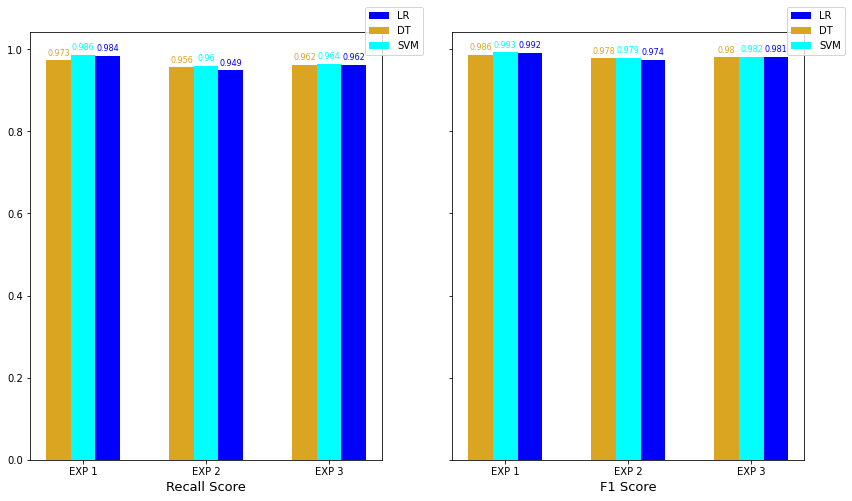

In [ ]:
paths=[f"Results/{m}_large_malware.json" for m in ['LR','DT','SVM']]
PreliminaryPlots(paths,['Recall','F1'])

<ipython-input-44-d28f55234049>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{output_dir}/Modelwise_{metric}{extra}.pdf",bbox_inches='tight')


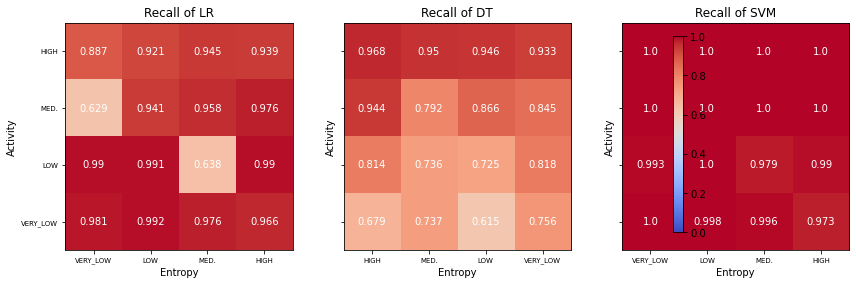

In [ ]:
# Recalls across vanilla models

paths=[f"Results/{m}_vanilla.json" for m in models]

PlotMetricAcrossModels(paths,models,'Recall')

<ipython-input-44-d28f55234049>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{output_dir}/Modelwise_{metric}{extra}.pdf",bbox_inches='tight')


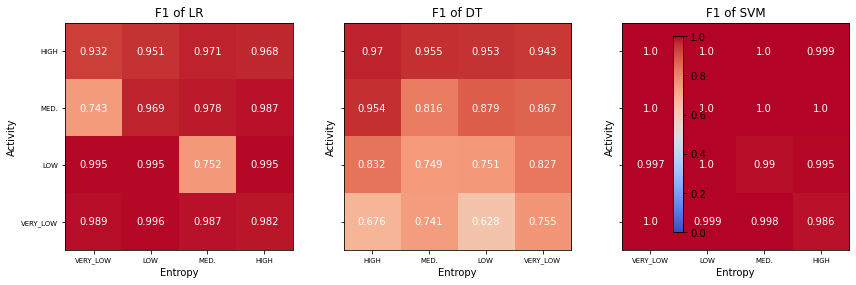

In [ ]:
# F1 score across vanilla models

paths=[f"Results/{m}_vanilla.json" for m in models]

PlotMetricAcrossModels(paths,models,'F1')

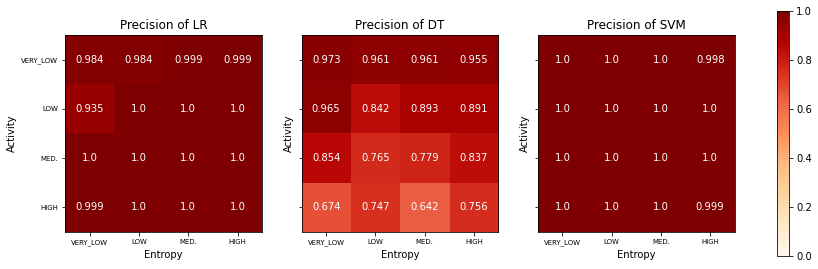

In [ ]:
# Precisions across vanilla models

paths=[f"Results/{m}_vanilla.json" for m in models]

PlotMetricAcrossModels(paths,models,'Precision')

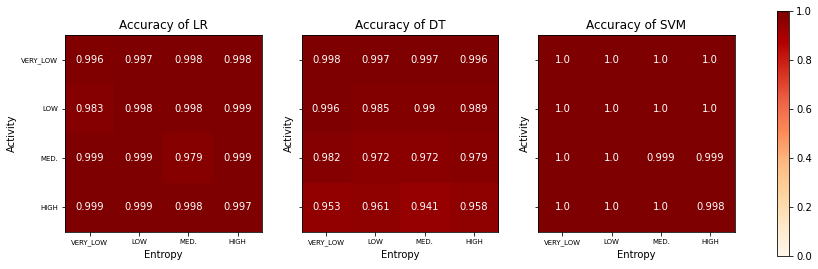

In [ ]:
# Accuracies across vanilla models

paths=[f"Results/{m}_vanilla.json" for m in models]

PlotMetricAcrossModels(paths,models,'Accuracy')

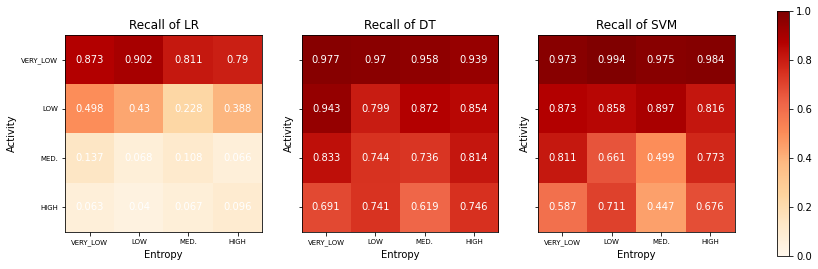

In [ ]:
# Recalls across models with architectural counters

paths=[f"Results/{m}_Architectural.json" for m in models]

PlotMetricAcrossModels(paths,models,'Recall',extra='_Architectural')

<ipython-input-44-d28f55234049>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{output_dir}/Modelwise_{metric}{extra}.pdf",bbox_inches='tight')


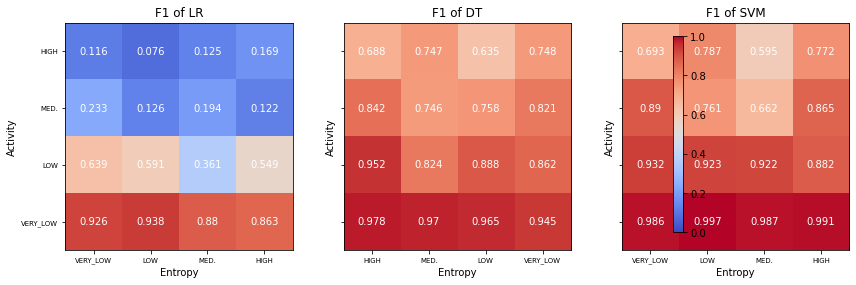

In [ ]:
# F1 score across models with architectural counters

paths=[f"Results/{m}_Architectural.json" for m in models]

PlotMetricAcrossModels(paths,models,'F1',extra='_Architectural')

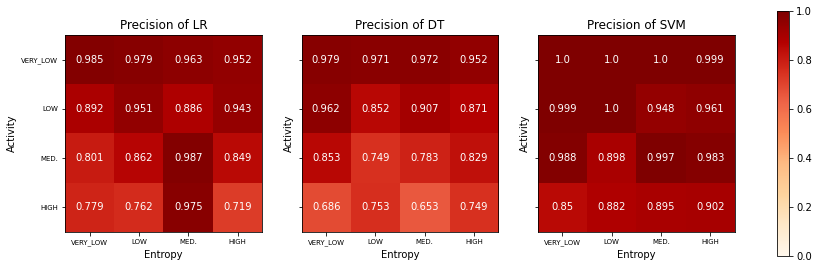

In [ ]:
# Precisions across models with architectural counters

paths=[f"Results/{m}_Architectural.json" for m in models]

PlotMetricAcrossModels(paths,models,'Precision','_Architectural')

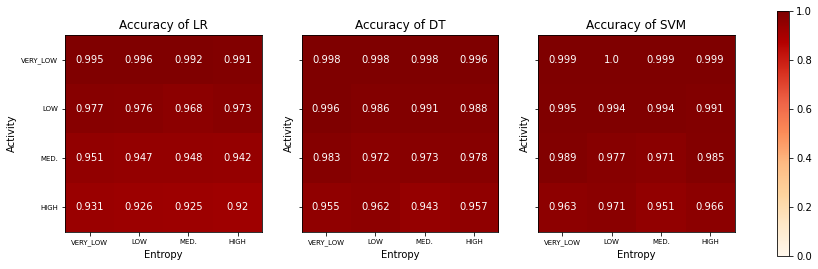

In [ ]:
# Precisions across models with architectural counters

paths=[f"Results/{m}_Architectural.json" for m in models]

PlotMetricAcrossModels(paths,models,'Accuracy','_Architectural')

Recall


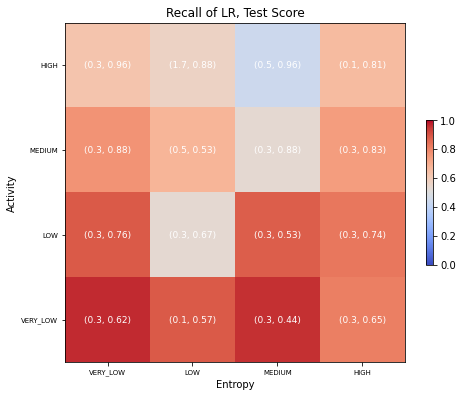

In [ ]:
# The plot below shows the best value for the lambda parameter
# used in a BoxCox transformation. The pair x,y in a cell represents
# the pair (best value of lambda, corresponding metric value).
# The left plot shows the scores obtained by Cross Validation
# The one on the right shows the corresponding test scores

values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model='Logistic'
PlotBoxCox(model,'recall',values)

F1


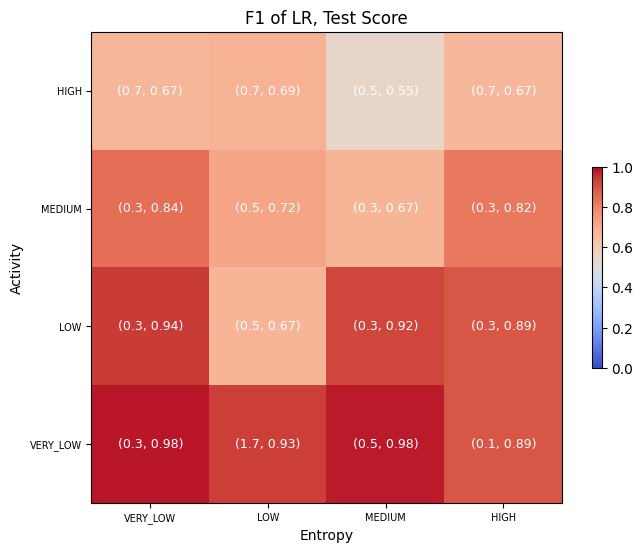

In [13]:
# Same as above, but considering f1 score.

values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model='Logistic'
PlotBoxCox(model,'f1',values)

F1


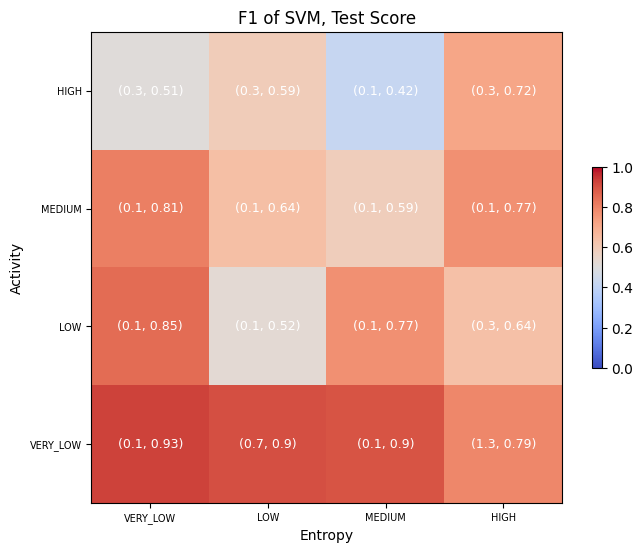

Recall


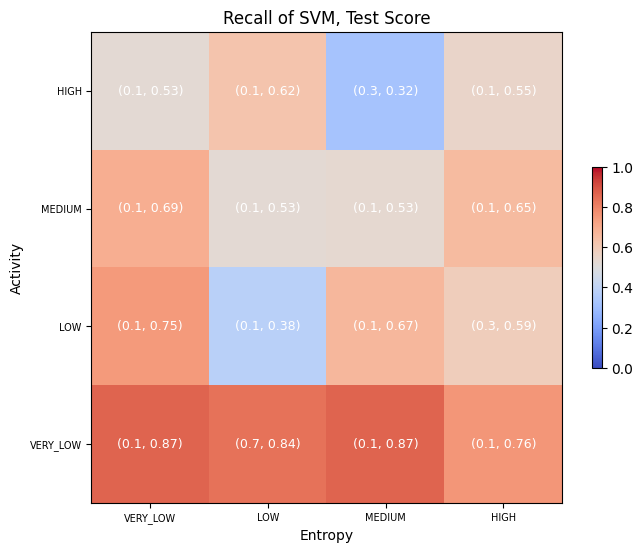

In [14]:
# Same as above, but considering recall and f1 score for svm.

values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model='SVM'
PlotBoxCox(model,'f1',values)

model='SVM'
PlotBoxCox(model,'recall',values)

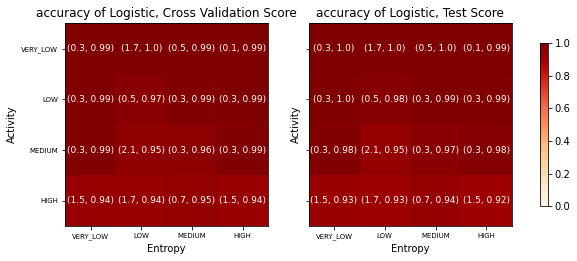

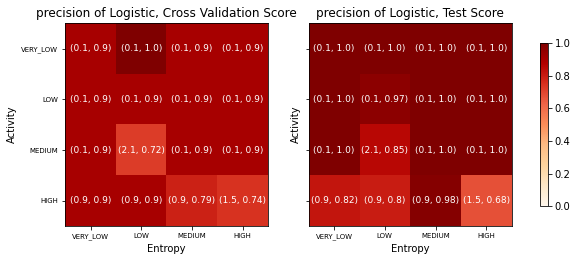

In [ ]:
values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model='Logistic'
PlotBoxCox(model,'accuracy',values)

model='Logistic'
PlotBoxCox(model,'precision',values)

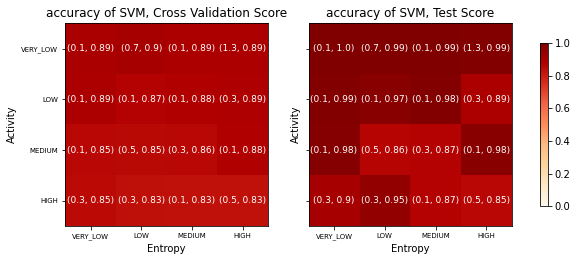

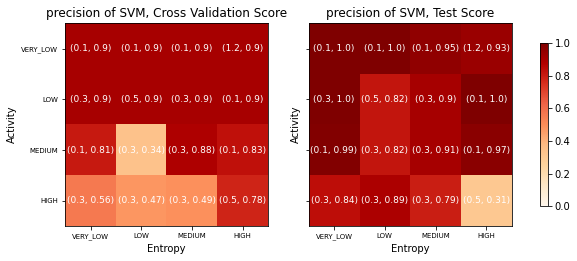

In [ ]:
values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model='SVM'
PlotBoxCox(model,'accuracy',values)

model='SVM'
PlotBoxCox(model,'precision',values)

In [ ]:
# Plot for results from Data Augmentain. Used for a fixed model

def PlotAugmented(model,path,metrics):
    
    n=len(metrics)
    fig, axs=plt.subplots(1,n,sharey=True)
    plots=[]
    
    # Create one heatmap for each metric. Add title and labels
    for i in range(n):
        title=metrics[i]

        axs[i].set_title(f"{title} of {model} with D.A.")
        axs[i].set_xlabel('Entropy')
        axs[i].set_ylabel('Activity')
        y_levels=levels.copy()
        y_levels.reverse()
        axs[i].set_xticks(np.arange(len(levels)), labels=levels, fontsize=7)
        axs[i].set_yticks(np.arange(len(levels)), labels=y_levels, fontsize=7)
        
        # Extract data and show matrix
        data_matrix=extract_metric_across_models([path],metrics[i])[0]
    
        p=axs[i].imshow(data_matrix,cmap='coolwarm',vmin=0,vmax=1)
        plots.append(p)

        # Color cells
        for j in range(len(levels)):
            for k in range(len(levels)):
                a=j
                e=k
                text = axs[i].text(k, j, f"{round(data_matrix[a][e],3)}" ,ha="center", va="center", color="w", fontsize=10)
        
    fig.set_size_inches(10,10)
    plt.colorbar(plots[0],cax=None,ax=axs,orientation='vertical',shrink=0.3)
    plt.savefig(f"{output_dir}/{model}_Augmentation.pdf",bbox_inches='tight')
    plt.show()

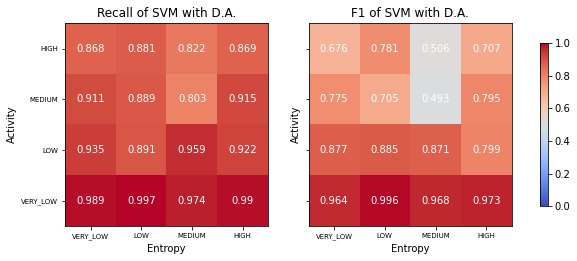

In [ ]:
model='SVM'
path="Results/TestScores/SVM_Architectural_Augment_gaussian_MalAugment.json"
metrics=["Recall",'F1']

PlotAugmented(model,path,metrics)

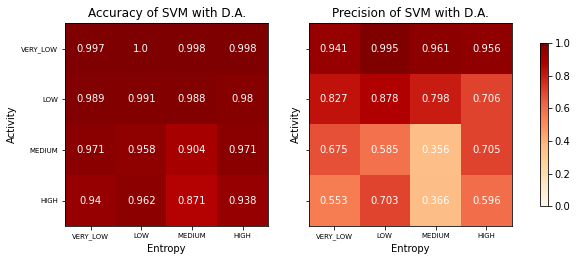

In [ ]:
model='SVM'
path="Results/TestScores/SVM_Architectural_Augment_gaussian_MalAugment.json"
metrics=["Accuracy",'Precision']

PlotAugmented(model,path,metrics)

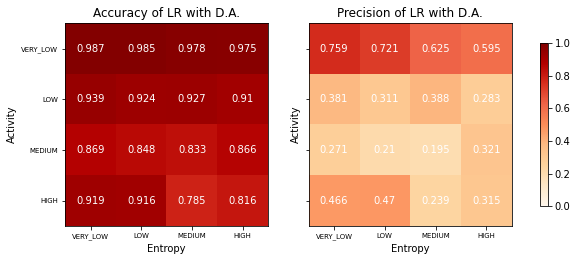

In [ ]:
model='LR'
path="Results/TestScores/Logistic_Architectural_Augment_gaussian_MalAugment.json"
metrics=["Accuracy",'Precision']

PlotAugmented(model,path,metrics)

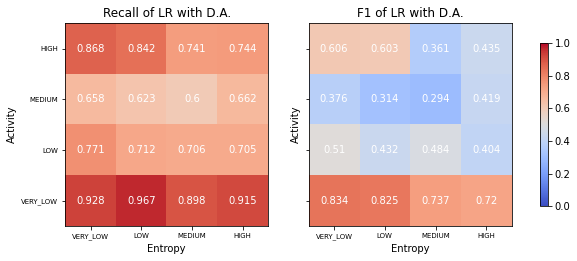

In [ ]:
model='LR'
path="Results/TestScores/Logistic_Architectural_Augment_gaussian_MalAugment.json"
metrics=["Recall",'F1']

PlotAugmented(model,path,metrics)

In [ ]:
# Plots a table showing the results of Forward Feature Selection
    
def PlotFeatureSelectionTable(counters,data,model_type):
        
  content=[]
  metaparam_combinations=[]

  fig, ax = plt.subplots(
            1,
            1,
            figsize=(5,5)
  )

  for key in itertools.product(levels,levels):

    combination='('+key[0]+','+key[1]+')'
    metaparam_combinations.append(combination)

    counter_list=data[key[0]][key[1]]
    new_row=[' ']*len(counters)

    for c in counter_list:
      i=counters.index(c)
      new_row[i]='X'
            
    content.append(new_row)

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')

    tab=ax.table(
            cellText=content,
            rowLabels=metaparam_combinations,
            colLabels=counters,
            cellLoc='center',
    )
    tab.scale(5,2)

    for key, cell in tab.get_celld().items():
      cell.set_linewidth(1)
      cell.set_fontsize(35)

  plt.savefig( f'{output_dir}/{model_type}_IterativeImportance.pdf',format='pdf',bbox_inches='tight')  
  plt.show()

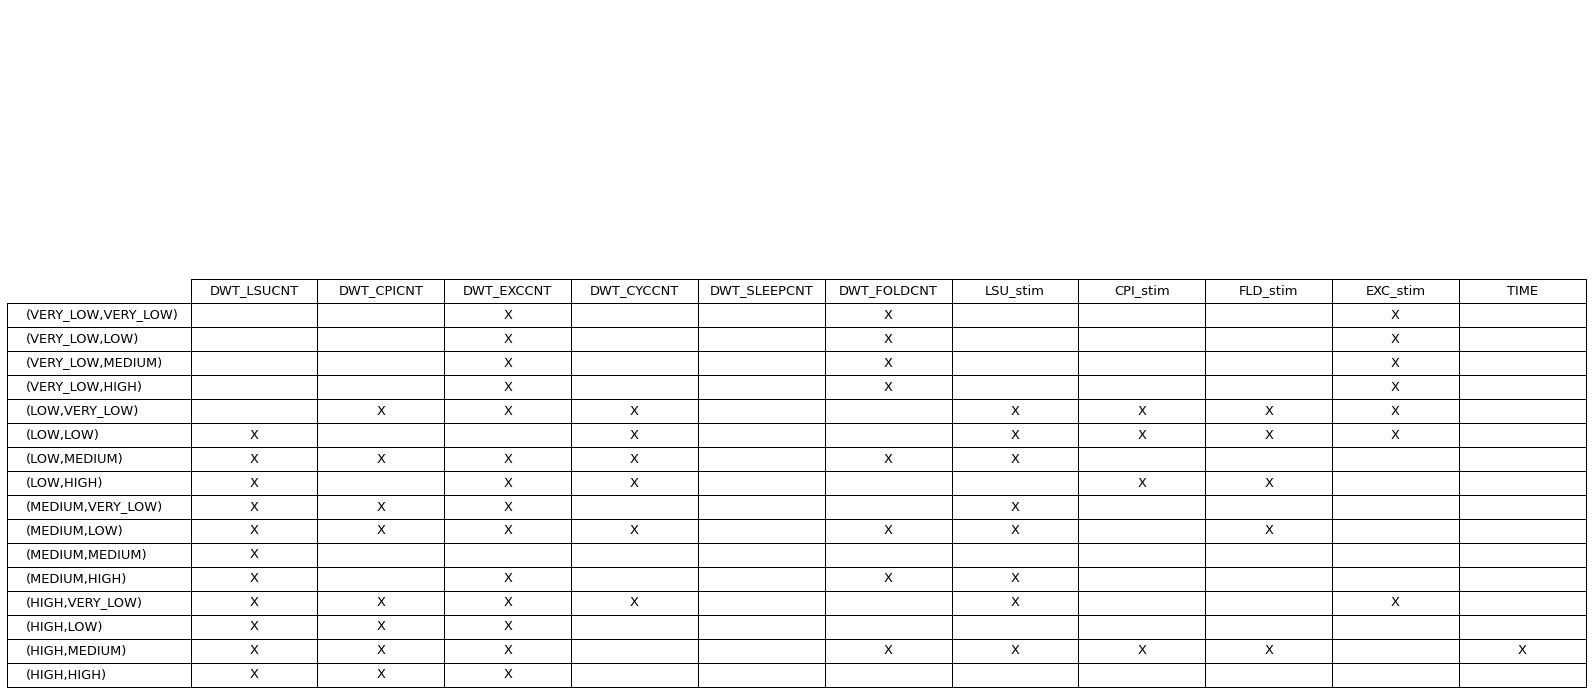

In [ ]:
model_type='SVM'

data=json_to_matrix(f"Results/Importance/{model_type}_CounterImportance.json")
PlotFeatureSelectionTable(counters,data,model_type)

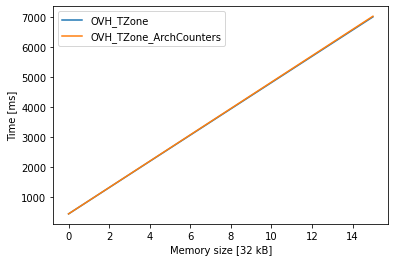

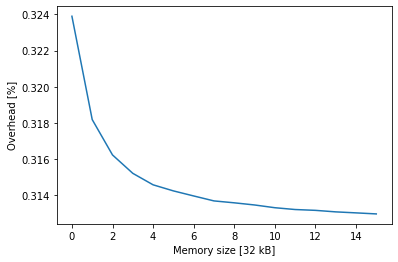

In [ ]:
# Auxiliary methods to plot overhead-related data

# Extract data as dictionary
def extract_ovh_data(path_list,setting_list):
    
    results={}
    
    for i,p in enumerate(path_list):
        results[setting_list[i]]= dict_to_list( json_to_matrix(p) )
        
    return results

# Convert to list
def dict_to_list(dictionary,contribution='AR_Contribution'):
    """
    Converts the results in a dictionary form to a list
    """
    
    if contribution in dictionary.keys():
        dictionary=dictionary[contribution]
    
    l=[]
    for i in range(0,16):
        key=str(i)
        if key in dictionary.keys():
            l.append(dictionary[key])
    
    f=dictionary['frequency_MHz']
    
    l2=[x*1000/(1*f*1e6) for x in l]
    return l2

# Plot time measurements
def PlotOverhead(data):
    """
    data is a dictionary of results, one for each setting that we considered.
    Each setting is described by a string in the form <OVH_[TZone_](ArchCounters|AllCounters)[_Overflow]>
    """
    
    fig, axs = plt.subplots(1,1)
    axs.set_xlabel('Memory size [32 kB]')
    axs.set_ylabel('Time [ms]')
    
    for setting in data.keys():
        axs.plot(data[setting],label=setting)
        
    handles,labels=axs.get_legend_handles_labels()
    axs.legend(handles,labels)
    plt.savefig(f'{output_dir}/GeneralOVH.pdf')
    plt.show()

# Plots the overhead w.r.t. Baseline Attestation
def PlotOVHPercentage(data,baseline):
    """
    Like the above method, but it computes overhead in percentage w.r.t. a baseline
    """
    
    fig, axs = plt.subplots(1,1)
    axs.set_xlabel('Memory size [32 kB]')
    axs.set_ylabel('Overhead [%]')
    
    baseline_data=data[baseline]
    
    for setting in data.keys():
        
        if setting !=baseline:
            perc_data=[((x-baseline_data[i])*100/baseline_data[i]) for i,x in enumerate(data[setting])]
            axs.plot(perc_data,label=setting)
        
    handles,labels=axs.get_legend_handles_labels()
    #axs.legend(handles,labels)
    plt.savefig(f'{output_dir}/GeneralOVHPercentage.pdf')
    plt.show()

paths=['Results/Overhead/RA_TrustZone.json','Results/Overhead/RA_TZone_ArchCounters.json']
settings=['OVH_TZone','OVH_TZone_ArchCounters']
d=extract_ovh_data(paths,settings)

PlotOverhead(d)
PlotOVHPercentage(d,settings[0])